# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

In [1]:
from exercise_code.networks.optimizer import sgd_momentum
import numpy as np
import os
from exercise_code.data.csv_dataset import CSVDataset
from exercise_code.data.csv_dataset import FeatureSelectorAndNormalizationTransform
from exercise_code.data.dataloader import DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None  # default='warn'

%matplotlib inline
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


First, we load the data as we did in the last task.

In [2]:
target_column = 'SalePrice'
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
root_path = os.path.join(i2dl_exercises_path, "datasets", 'housing')
housing_file_path = os.path.join(root_path, "housing_train.csv")
download_url = 'https://cdn3.vision.in.tum.de/~dl4cv/housing_train.zip'

# Always make sure this line was run at least once before trying to
# access the data manually, as the data is downloaded in the 
# constructor of CSVDataset.
train_dataset = CSVDataset(target_column=target_column, root=root_path, download_url=download_url, mode="train")

In [3]:
df = train_dataset.df
target_column = 'SalePrice'
# Select only 2 features to keep plus the target column.
selected_columns = ['GrLivArea', target_column]
mn, mx, mean = df.min(), df.max(), df.mean()

column_stats = {}
for column in selected_columns:
    crt_col_stats = {'min' : mn[column],
                     'max' : mx[column],
                     'mean': mean[column]}
    column_stats[column] = crt_col_stats    

transform = FeatureSelectorAndNormalizationTransform(column_stats, target_column)

def rescale(data, key = "SalePrice", column_stats = column_stats):
    """ Rescales input series y"""
    mx = column_stats[key]["max"]
    mn = column_stats[key]["min"]

    return data * (mx - mn) + mn

In [4]:
train_dataset = CSVDataset(mode="train", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
val_dataset = CSVDataset(mode="val", target_column=target_column, root=root_path, download_url=download_url, transform=transform)
test_dataset = CSVDataset(mode="test", target_column=target_column, root=root_path, download_url=download_url, transform=transform)

print("Number of training samples:", len(train_dataset))
print("Number of validation samples:", len(val_dataset))
print("Number of test samples:", len(test_dataset))

Number of training samples: 876
Number of validation samples: 292
Number of test samples: 292


In [5]:
from exercise_code.networks.optimizer import SGD, sgd_momentum, Adam
from exercise_code.networks.loss import MSE

In [6]:
from exercise_code.networks.regression_net import RegressionNet
from exercise_code.solver import Solver

batch_size = 2
lr = 1e-3
hidden_size = 1
std = 1.
epochs = 20

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Stochastic Gradient Descent
You have implemented the SGD in previous tasks, now lets look at it again.
In stochastic gradient descent, the true gradient of $L(\theta)$ is approximated by a gradient at a single example/mini-batch:
$${\displaystyle \theta:=\theta-\eta \nabla L(\theta)=\theta-{\frac {\eta }{n}}\sum _{i=1}^{n}\nabla L_{i}(\theta),}$$
Here is how the training and validation curve looks like.

running with SGD 
(Epoch 1 / 20) train loss: 0.011751; val loss: 0.011177
(Epoch 2 / 20) train loss: 0.011193; val loss: 0.010631
(Epoch 3 / 20) train loss: 0.010865; val loss: 0.010625
(Epoch 4 / 20) train loss: 0.010821; val loss: 0.010631
(Epoch 5 / 20) train loss: 0.010807; val loss: 0.010627
(Epoch 6 / 20) train loss: 0.010796; val loss: 0.010619
(Epoch 7 / 20) train loss: 0.010786; val loss: 0.010609
(Epoch 8 / 20) train loss: 0.010777; val loss: 0.010599
(Epoch 9 / 20) train loss: 0.010767; val loss: 0.010589
(Epoch 10 / 20) train loss: 0.010757; val loss: 0.010579
(Epoch 11 / 20) train loss: 0.010747; val loss: 0.010569
(Epoch 12 / 20) train loss: 0.010737; val loss: 0.010559
(Epoch 13 / 20) train loss: 0.010727; val loss: 0.010549
(Epoch 14 / 20) train loss: 0.010718; val loss: 0.010539
(Epoch 15 / 20) train loss: 0.010708; val loss: 0.010529
(Epoch 16 / 20) train loss: 0.010698; val loss: 0.010519
(Epoch 17 / 20) train loss: 0.010688; val loss: 0.010510
(Epoch 18 / 20) train 

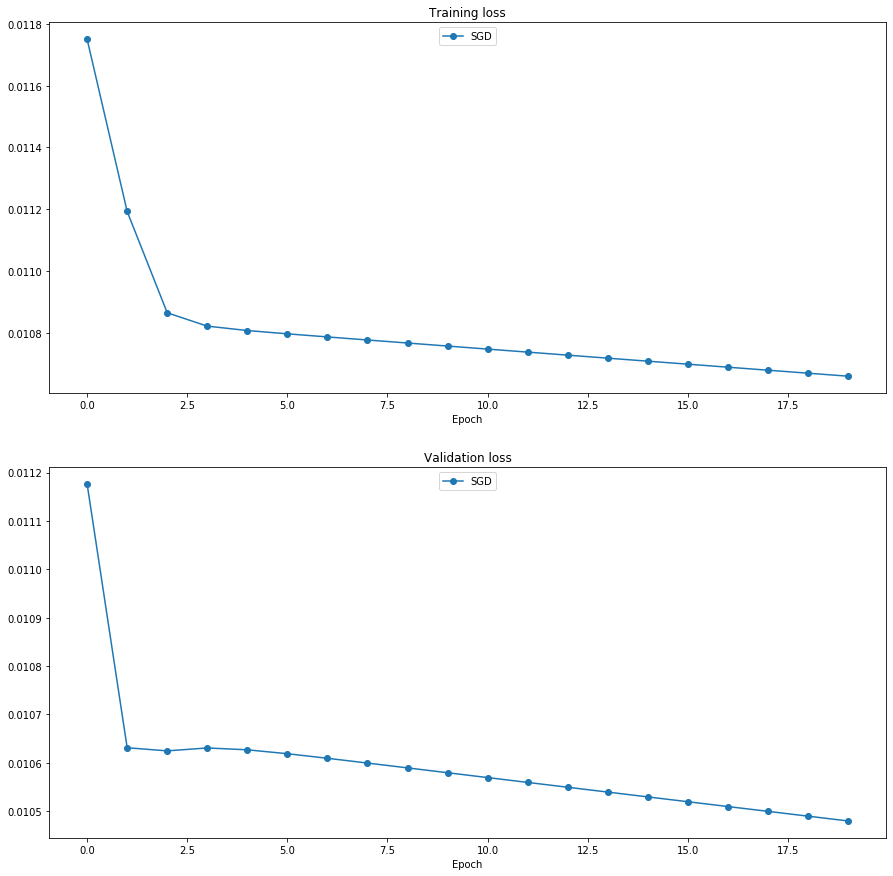

In [7]:
solvers = {}

print('running with SGD ')
model = RegressionNet(input_size=1, hidden_size=hidden_size, std=std)

solver = Solver(model, train_dataloader, val_dataloader, learning_rate=lr,
                    loss_func=MSE(), optimizer=SGD)

solvers[0] = solver
solver.train(20)


ax1 = plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')

ax2 = plt.subplot(2, 1, 2)
plt.title('Validation loss')
plt.xlabel('Epoch')

ax1 = plt.subplot(2, 1, 1)
ax1.plot(solver.train_loss_history, '-o', label='SGD')

ax2 = plt.subplot(2, 1, 2)
ax2.plot(solver.val_loss_history, '-o', label='SGD')

for i in [1, 2]:
    ax = plt.subplot(2, 1, i)
    ax.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.
$$v^{k+1} = \beta v^{k} - \alpha \nabla_{\theta} L (\theta^{k}) $$

$$\theta^{k+1} = \theta^{k} + v^{k+1}$$

Open the file `exercise_code/networks/optimizer.py` and read the documentation at the top of the file to make sure you understand the API. We have implemented the SGD+momentum update rule in the class `sgd_momentum` for you.
Check it out to make sure you understand it fully.


Now lets see how the training and validation curve looks like.

In [ ]:
solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
    
    print('running with ', update_rule)
    model = RegressionNet(input_size=1, hidden_size=hidden_size, std=std)
    
    if update_rule == 'sgd_momentum':
        solver = Solver(model, train_dataloader, val_dataloader, learning_rate=lr,
                        loss_func=MSE(), optimizer=sgd_momentum)
    
    elif update_rule == 'sgd':
        solver = Solver(model, train_dataloader, val_dataloader, learning_rate=lr, 
                        loss_func=MSE(), optimizer=SGD)
    
    solvers[update_rule] = solver
    solver.train(20)
    

ax1 = plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')

ax2 = plt.subplot(2, 1, 2)
plt.title('Validation loss')
plt.xlabel('Epoch')


for update_rule, solver in solvers.items():
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(solver.train_loss_history, '-o', label=update_rule)
  
    ax2 = plt.subplot(2, 1, 2)
    ax2.plot(solver.val_loss_history, '-o', label=update_rule)

for i in [1, 2]:
    ax = plt.subplot(2, 1, i)
    ax.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

running with  sgd
(Epoch 1 / 20) train loss: 0.011751; val loss: 0.011177
(Epoch 2 / 20) train loss: 0.011193; val loss: 0.010631
(Epoch 3 / 20) train loss: 0.010865; val loss: 0.010625
(Epoch 4 / 20) train loss: 0.010821; val loss: 0.010631
(Epoch 5 / 20) train loss: 0.010807; val loss: 0.010627
(Epoch 6 / 20) train loss: 0.010796; val loss: 0.010619
(Epoch 7 / 20) train loss: 0.010786; val loss: 0.010609
(Epoch 8 / 20) train loss: 0.010777; val loss: 0.010599
(Epoch 9 / 20) train loss: 0.010767; val loss: 0.010589
(Epoch 10 / 20) train loss: 0.010757; val loss: 0.010579
(Epoch 11 / 20) train loss: 0.010747; val loss: 0.010569
(Epoch 12 / 20) train loss: 0.010737; val loss: 0.010559
(Epoch 13 / 20) train loss: 0.010727; val loss: 0.010549
(Epoch 14 / 20) train loss: 0.010718; val loss: 0.010539
(Epoch 15 / 20) train loss: 0.010708; val loss: 0.010529
(Epoch 16 / 20) train loss: 0.010698; val loss: 0.010519
(Epoch 17 / 20) train loss: 0.010688; val loss: 0.010510
(Epoch 18 / 20) train 

# Adam
Adam [1] is an update rule that sets per-parameter learning rates by using a running average of the second moments of gradients.

$$
\begin{array}{l}\nu_{t}=\beta_{1} * \nu_{t-1}-\left(1-\beta_{1}\right) * g_{t} \\ s_{t}=\beta_{2} * s_{t-1}-\left(1-\beta_{2}\right) * g_{t}^{2} \\ \Delta \theta_{t}=-\eta \frac{\nu_{t}}{\sqrt{s_{t}+\epsilon}} * g_{t} \\ \theta_{t+1}=\theta_{t}+\Delta \theta_{t}\end{array}
$$

$$
\begin{array}{l}\eta: \text { Initial Learning rate} \\ g_{t}: \text { Gradient at time t along } \theta^{j} \\ \nu_{t}: \text { Exponential Average of gradients along } \theta_{j} \\ s_{t}: \text { Exponential Average of squares of gradients along } \theta_{j} \\ \beta_{1}, \beta_{2}: \text { Hyperparameters}\end{array}
$$

In the file `exercise_code/networks/optimizer.py`, we have implemented the update rule `adam` for you. Check this implementation and make sure you understand what the optimizer is doing. Then train the fully connected net below to see how Adam affects the learning process.

[1] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
#learning_rates = {'adam': 8e-4}
update_rule = 'adam'
print('running with ', update_rule)
model = RegressionNet(input_size=1, hidden_size=hidden_size, std=std)
solver = Solver(model, train_dataloader, val_dataloader, learning_rate=lr, loss_func=MSE(), optimizer=Adam)

solvers[update_rule] = solver
solver.train(20)
print()

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.xlabel('Epoch')

plt.subplot(2, 1, 2)
plt.title('Validation loss')
plt.xlabel('Epoch')



for update_rule, solver in solvers.items():
    ax1 = plt.subplot(2, 1, 1)
    plt.plot(solver.train_loss_history, '-o', label=update_rule)
  
    ax2 =plt.subplot(2, 1, 2)
    plt.plot(solver.val_loss_history, '-o', label=update_rule)

for i in [1, 2]:
    plt.subplot(2, 1, i)
    plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()